# Assignment 1 - Gioele Modica

# Code

## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

## Load dataset

In [ ]:
def load_data():
    # Load the MNIST dataset, ignoring the labels
    (x_train, _), (x_test, _) = mnist.load_data()
    # Convert the pixel values from integers to floats and normalize them to the range [0, 1].
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    # Reshape the training and testing data to include a channel dimension
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
    return x_train, x_test

## Random noise

In [ ]:
def generate_random_noise(batch_size=10):
    # Generates random noise from a normal (Gaussian) distribution.
    return np.random.normal(loc=0.5, scale=0.5, size=(batch_size, 28, 28, 1))

def add_noise(x, noise_factor=0.5):
    # Adds noise to the input iamge 'x'.
    noisy_data = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    # Ensures that the noisy data is clipped to stay within the range [0, 1],
    return np.clip(noisy_data, 0., 1.)

##Build denoising autoencoder

In [ ]:
def build_denoising_autoencoder():
    # Define the input layer with 784 features (flattened 28x28 image).
    input_img = Input(shape=(784,))
    # Create a series of Dense layers for the encoding part.
    encoded = Dense(256, activation='relu')(input_img)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    # Create a series of Dense layers for the decoding part.
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    # Define the autoencoder model.
    autoencoder = Model(input_img, decoded)
    # Compile the model with an optimizer and loss function.
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

 ## Contractive loss for contractive autoencoder

In [ ]:
def contractive_loss(model, lambd):
    # Define a custom loss function for contractive autoencoder.
    def loss(y_true, y_pred):
        # Compute the average binary cross-entropy loss between true and predicted values.
        reconstruction_loss = K.mean(K.binary_crossentropy(y_true, y_pred))
        # Initialize contractive loss.
        contractive_loss = 0
        # Iterate over each layer in the model.
        for layer in model.layers:
            # Check if the layer is part of the encoder.
            if 'encoder' in layer.name:
                # Get the weights of the layer.
                weights = layer.trainable_weights[0]
                # Compute the sum of squares of the weights.
                weights_jsqr = K.sum(K.square(weights))
                # Accumulate the contractive loss.
                contractive_loss += weights_jsqr
        # Combine the reconstruction and contractive losses.
        return reconstruction_loss + lambd * contractive_loss
    return loss

## Build contractive autoencoder

In [ ]:
def build_contractive_autoencoder(lambd=1e-8):
    # Define the input layer with a shape suitable for a flattened 28x28 image.
    input_img = Input(shape=(784,))
    # Sequentially add dense layers for the encoding part, with each named to identify as part of the encoder.
    encoded = Dense(256, activation='relu', name='encoder1')(input_img)
    encoded = Dense(128, activation='relu', name='encoder2')(encoded)
    encoded = Dense(64, activation='relu', name='encoder3')(encoded)
    encoded = Dense(32, activation='relu', name='encoder4')(encoded)
    # Sequentially add dense layers for the decoding part.
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    # Construct the autoencoder model mapping inputs to decoded outputs.
    autoencoder = Model(input_img, decoded)
    # Compile the model with an Adam optimizer and a custom contractive loss function.
    autoencoder.compile(optimizer='adam', loss=contractive_loss(autoencoder, lambd))
    return autoencoder

## Training

In [ ]:
def train_model(model, x_train, x_train_noisy, x_test, x_test_noisy, epochs=50):
    # Setup an EarlyStopping callback to halt training when validation loss stops improving.
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model using noisy data as input and clean data as targets.
    # Includes shuffling of data and uses early stopping based on validation loss.
    model.fit(x_train_noisy, x_train,
              epochs=epochs,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_noisy, x_test),
              callbacks=[early_stopping])

## Gradient ascent

In [ ]:
def gradient_ascent_step(model, image, learning_rate=1.0):
    # Create a context for computing gradients.
    with tf.GradientTape() as tape:
        tape.watch(image)
        # Get the model's reconstruction of the image.
        reconstruction = model(image)
        # Calculate the loss as the mean squared error between the original and reconstructed images.
        loss = tf.reduce_mean(tf.square(reconstruction - image))
    # Compute gradients of the loss with respect to the image.
    grads = tape.gradient(loss, image)
    # Adjust the image by gradients scaled by the learning rate.
    new_image = image + learning_rate * grads
    return new_image, loss

def apply_gradient_ascent(model, initial_images, iterations=500, model_type='dae', tol=1e-5):
    # Iterate over the number of specified iterations.
    images = initial_images
    old_loss = None
    for i in range(iterations):
        # Perform a gradient ascent step.
        images, loss = gradient_ascent_step(model, images)
        # Check for convergence by comparing the change in loss to a tolerance.
        if old_loss is not None and abs(old_loss - loss.numpy()) < tol:
            print(f"[{model_type}]Iteration {i+1}: Converged with Loss = {loss.numpy()}")
            break
        old_loss = loss.numpy()
        # print the loss every 5 iterations.
        if (i + 1) % 5 == 0:
            print(f"[{model_type}]Iteration {i+1}: Loss = {loss.numpy()}")
    # Generate the final reconstruction from the last image.
    final_reconstruction = model(images)
    return images, final_reconstruction


## Display results function

In [ ]:
def display_images(orig, noise, denoised, title):
    # Get the number of images to display.
    n = len(orig)
    # Create a figure with a specified size.
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display the original images.
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the noisy images.
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noise[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display the denoised images.
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

## Building models

In [ ]:
x_train, x_test = load_data()
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

dae = build_denoising_autoencoder()
cae = build_contractive_autoencoder()

## Denoising autoencoder summary

In [ ]:
dae.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 256)               200960    
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                                 
 dense_29 (Dense)            (None, 128)               8320

## Contractive autoencoder summary

In [ ]:
cae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder1 (Dense)            (None, 256)               200960    
                                                                 
 encoder2 (Dense)            (None, 128)               32896     
                                                                 
 encoder3 (Dense)            (None, 64)                8256      
                                                                 
 encoder4 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 64)                2112      
                                                                 
 dense_33 (Dense)            (None, 128)               8320

## Train denoising autoencoder

In [ ]:
train_model(dae, x_train.reshape(-1, 784), x_train_noisy.reshape(-1, 784), x_test.reshape(-1, 784), x_test_noisy.reshape(-1, 784))

Epoch 1/50
235/235 [==============================] - 7s 22ms/step - loss: 0.2642 - val_loss: 0.2104
Epoch 2/50
235/235 [==============================] - 6s 27ms/step - loss: 0.1834 - val_loss: 0.1693
Epoch 3/50
235/235 [==============================] - 5s 20ms/step - loss: 0.1638 - val_loss: 0.1574
Epoch 4/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1537 - val_loss: 0.1500
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1469 - val_loss: 0.1439
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1412 - val_loss: 0.1386
Epoch 7/50
235/235 [==============================] - 6s 27ms/step - loss: 0.1367 - val_loss: 0.1353
Epoch 8/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1332 - val_loss: 0.1322
Epoch 9/50
235/235 [==============================] - 5s 23ms/step - loss: 0.1307 - val_loss: 0.1305
Epoch 10/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1284 - val_lo

## Train contractive autoencoder

In [ ]:
train_model(cae, x_train.reshape(-1, 784), x_train_noisy.reshape(-1, 784), x_test.reshape(-1, 784), x_test_noisy.reshape(-1, 784))

Epoch 1/50
235/235 [==============================] - 12s 31ms/step - loss: 0.2653 - val_loss: 0.2225
Epoch 2/50
235/235 [==============================] - 7s 29ms/step - loss: 0.1931 - val_loss: 0.1709
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1631 - val_loss: 0.1573
Epoch 4/50
235/235 [==============================] - 6s 24ms/step - loss: 0.1517 - val_loss: 0.1478
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.1447 - val_loss: 0.1420
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1391 - val_loss: 0.1367
Epoch 7/50
235/235 [==============================] - 6s 27ms/step - loss: 0.1344 - val_loss: 0.1330
Epoch 8/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1308 - val_loss: 0.1302
Epoch 9/50
235/235 [==============================] - 6s 27ms/step - loss: 0.1279 - val_loss: 0.1275
Epoch 10/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1259 - val_l

## Adding noise to MINST images

In [ ]:
idxs = np.random.choice(len(x_test), 10, replace=False)
test_images = x_test[idxs]
test_images_noisy = x_test_noisy[idxs]

## Denoising autoencoder prediction - MINST images

1/1 [==============================] - 0s 20ms/step


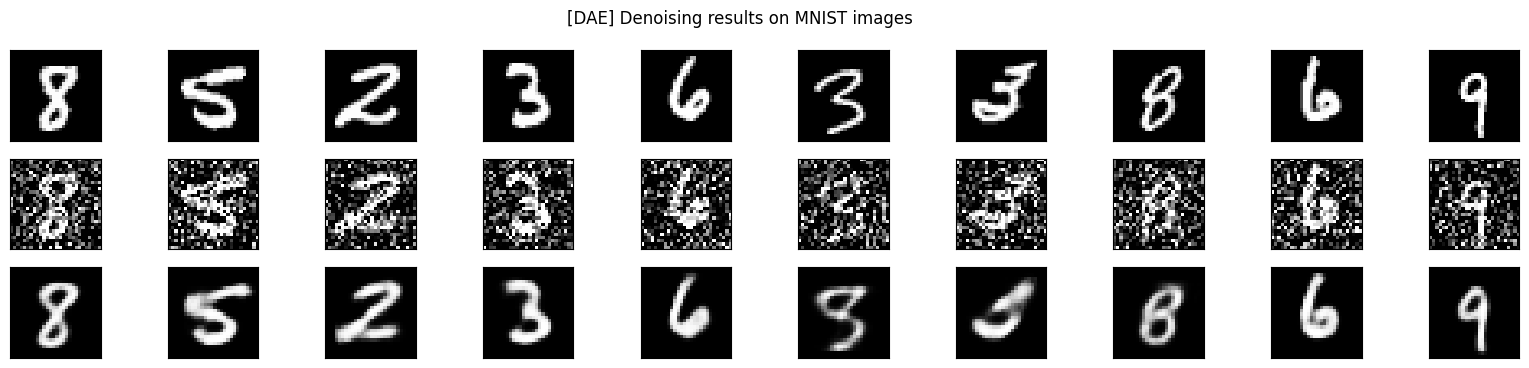

In [ ]:
test_images_denoised = dae.predict(test_images_noisy.reshape(-1, 784)).reshape(-1, 28, 28, 1)
display_images(test_images, test_images_noisy, test_images_denoised, "[DAE] Denoising results on MNIST images")


## Contractive autoencoder prediction - MINST images

1/1 [==============================] - 0s 21ms/step


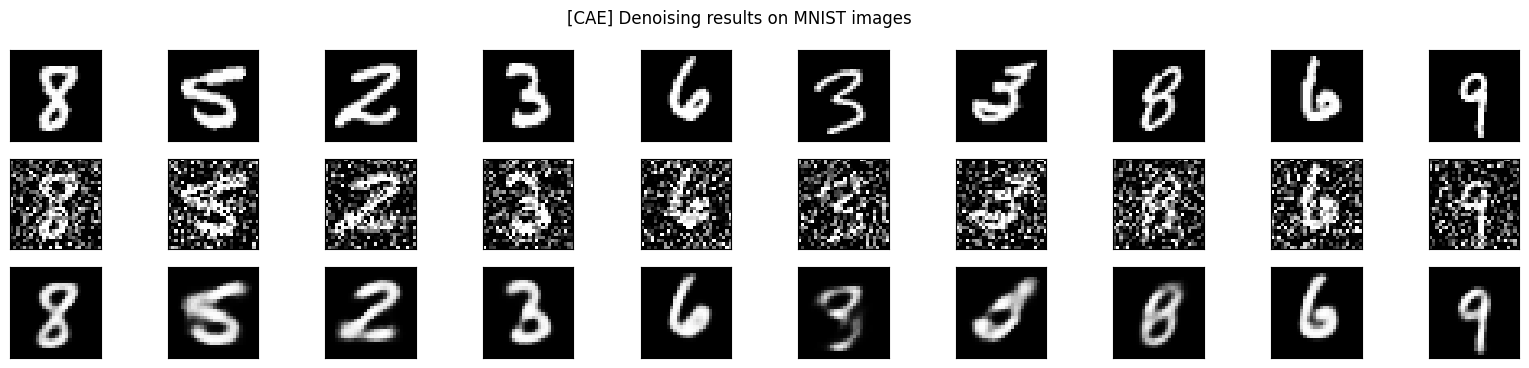

In [ ]:
test_images_denoised_cae = cae.predict(test_images_noisy.reshape(-1, 784)).reshape(-1, 28, 28, 1)
display_images(test_images, test_images_noisy, test_images_denoised_cae, "[CAE] Denoising results on MNIST images")

## Creating reandom noise images

In [ ]:
# Generate batch of random noise images
random_noise_images = generate_random_noise()
# Convert random noise images to a tensor
random_noise_tensor = tf.convert_to_tensor(random_noise_images, dtype=tf.float32)

## Denoising autoencoder final results

[denoising_autoencoder]Iteration 5: Loss = 0.4145086705684662
[denoising_autoencoder]Iteration 10: Loss = 0.41738736629486084
[denoising_autoencoder]Iteration 15: Loss = 0.42017385363578796
[denoising_autoencoder]Iteration 20: Loss = 0.4227299392223358
[denoising_autoencoder]Iteration 25: Loss = 0.42540425062179565
[denoising_autoencoder]Iteration 30: Loss = 0.42820030450820923
[denoising_autoencoder]Iteration 35: Loss = 0.4307156205177307
[denoising_autoencoder]Iteration 40: Loss = 0.43294695019721985
[denoising_autoencoder]Iteration 45: Loss = 0.4351550042629242
[denoising_autoencoder]Iteration 50: Loss = 0.43717795610427856
[denoising_autoencoder]Iteration 55: Loss = 0.43909236788749695
[denoising_autoencoder]Iteration 60: Loss = 0.4409460425376892
[denoising_autoencoder]Iteration 65: Loss = 0.44271120429039
[denoising_autoencoder]Iteration 70: Loss = 0.4445030987262726
[denoising_autoencoder]Iteration 75: Loss = 0.4464368224143982
[denoising_autoencoder]Iteration 80: Loss = 0.44838

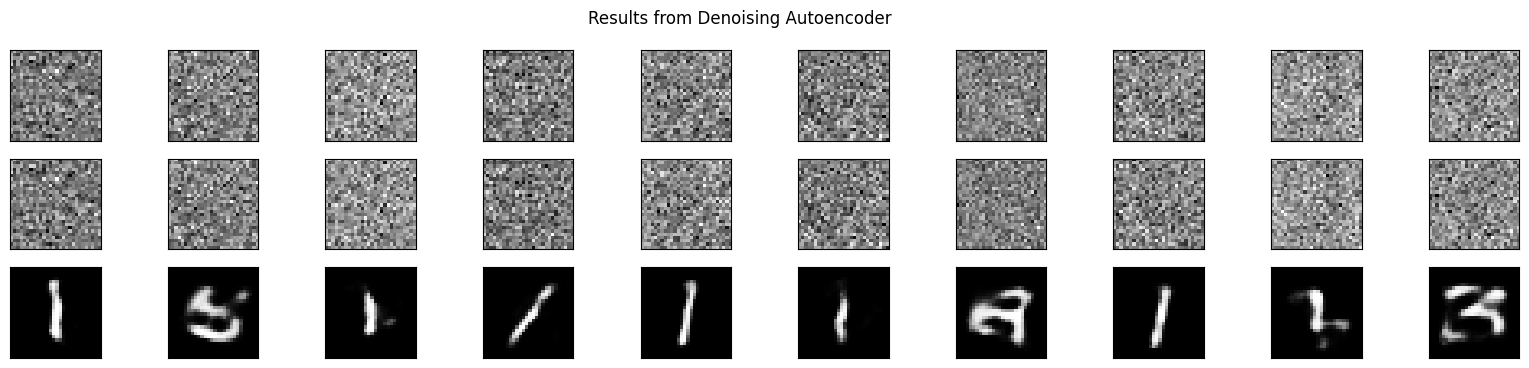

In [ ]:
final_images_dae, reconstructions_dae = apply_gradient_ascent(dae, tf.reshape(random_noise_tensor, (-1, 784)), model_type='denoising_autoencoder')
display_images(random_noise_images, final_images_dae.numpy().reshape(-1, 28, 28, 1), reconstructions_dae.numpy().reshape(-1, 28, 28, 1), "Results from Denoising Autoencoder")

## Contractive autoencoder final results

[contractive_autoencoder]Iteration 5: Loss = 0.41295066475868225
[contractive_autoencoder]Iteration 10: Loss = 0.4152052402496338
[contractive_autoencoder]Iteration 15: Loss = 0.41728267073631287
[contractive_autoencoder]Iteration 20: Loss = 0.41927340626716614
[contractive_autoencoder]Iteration 25: Loss = 0.4212336838245392
[contractive_autoencoder]Iteration 30: Loss = 0.42314791679382324
[contractive_autoencoder]Iteration 35: Loss = 0.42499297857284546
[contractive_autoencoder]Iteration 40: Loss = 0.4267692267894745
[contractive_autoencoder]Iteration 45: Loss = 0.42846179008483887
[contractive_autoencoder]Iteration 50: Loss = 0.4301408529281616
[contractive_autoencoder]Iteration 55: Loss = 0.4317830502986908
[contractive_autoencoder]Iteration 60: Loss = 0.43339037895202637
[contractive_autoencoder]Iteration 65: Loss = 0.43498000502586365
[contractive_autoencoder]Iteration 70: Loss = 0.43654337525367737
[contractive_autoencoder]Iteration 75: Loss = 0.4380791485309601
[contractive_auto

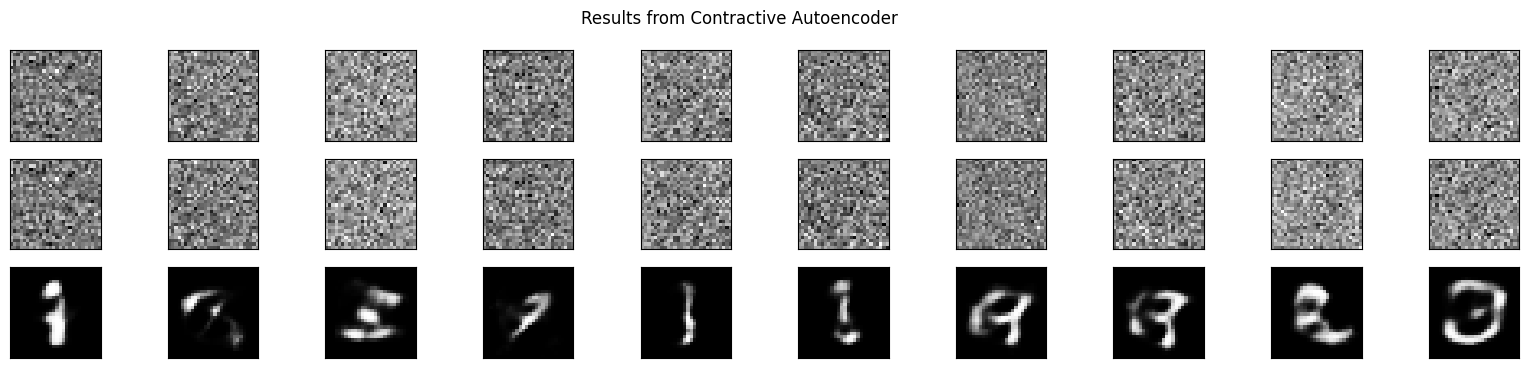

In [ ]:
final_images_cae, reconstructions_cae = apply_gradient_ascent(cae, tf.reshape(random_noise_tensor, (-1, 784)), model_type='contractive_autoencoder')
display_images(random_noise_images, final_images_cae.numpy().reshape(-1, 28, 28, 1), reconstructions_cae.numpy().reshape(-1, 28, 28, 1), "Results from Contractive Autoencoder")

# Analysis


## Data loading and preparation

The MNIST dataset is loaded and preprocessed. The preprocessing includes normalization to scale pixel values between 0 and 1 and reshaping to fit the autoencoder input requirements.

### Noise addition

Functions are defined to generate random noise and to add this noise to the clean MNIST images. This simulates real-world scenarios where data may be corrupted by various factors.

## Autoencoder construction

### Denoising autoencoder

Comprises an encoder that compresses the input into a smaller, dense representation and a decoder that attempts to reconstruct the input from this compressed form. The model aims to clean the noisy images by learning to ignore the noise during training.

###Contractive autoencoder
Similar in structure to the DAE but includes a custom loss function. This function adds a contractive term to the standard reconstruction loss, which penalizes large weights to encourage robust feature learning.
### Training

Both autoencoders are trained using the noisy images as input and the clean images as targets. Early stopping is implemented to prevent overfitting.

### Gradient ascent

A method to iteratively enhance the image quality by adjusting the input image based on the gradient of the loss function with respect to the input. This method tests whether the autoencoders can refine random noise into something resembling the dataset’s manifold, i.e., digit-like structures.

 ### Experimentation and results Visualization

After training, the autoencoders are tested with both noisy MNIST  images to test their skills and entirely random noise images. The results are visualized in a series of plots that compare the original images, the added noise, and the reconstructions from each autoencoder.

 ## Result analisys

This experiment emphasizes comparing the effectiveness of the two autoencoders in handling noise and their ability to recover data characteristics from random noise inputs. The experiment with gradient ascent is particularly insightful as it explores whether the trained autoencoders can "imagine" digits from noise, essentially testing the limits of their generative capabilities.

The visualization of outputs plays a crucial role in interpreting the autoencoders' performance. It provides a qualitative assessment of how well each model reconstructs and denoises but also offers insights into the models' different learning and generalization behaviors.

## Denoising Autoencoder (DAE) Results Analysis

### Top Row
Displays the progression of random noise images as they are input into the DAE. The noise appears uniform across all samples, providing no discernible structure or patterns indicative of the MNIST digits.

### Bottom Row
Reveals the reconstructed outputs after the noise has passed through the DAE. The transformation from noise to recognizable digits is remarkable, indicating that the DAE has learned to interpret underlying patterns even in highly corrupted inputs. The images of digits like '1', '5', '1', and '2' are notably clearer, suggesting the DAE's effectiveness in capturing and enhancing features relevant to MNIST digits from mere noise.

## Contractive Autoencoder (CAE) Results Analysis

In both plots the middle line shows the noise after applying gradient ascent

### Top Row

Similar to the DAE, it starts with the same input of random noise. The consistency in noise patterns ensures that any differences in output between the two models can be attributed to their architectural and functional distinctions.

### Bottom Row
The CAE outputs demonstrate its ability to generate digit-like images from noise. However, the CAE seems to produce slightly more blurred and less distinct images compared to the DAE. While still recognizable, digits such as '2', '1', '4', and '3' exhibit less clarity and precision in their reconstruction.

## Comparative Analysis

### Clarity and Detail

The DAE tends to produce clearer and more detailed images, which could be attributed to its focus on minimizing the impact of noise on the reconstructed output.

### Smoothness and Generalization
The CAE, while slightly blurrier, shows a robust ability to generalize from highly corrupted inputs. This might be due to the contractive loss, which not only penalizes reconstruction error but also the sensitivity of the hidden representation to the input, leading to more generalized features.

# Considerations

Both autoencoders demonstrate impressive capabilities in generating coherent digit images from random noise, highlighting their potential in tasks involving denoising and data recovery. The DAE excels in producing more precise reconstructions, making it suitable for applications requiring high fidelity. In contrast, the CAE offers robustness and might be preferred in scenarios where a more regularized, generalized representation is beneficial.


This experiment has been my favorite, largely because of the indistinguishable visual feedback provided by the transformations of random noise into recognizable digits. This clear visual distinction between the input noise and the output images allowed me to perform in-depth analyses and understand whether the models were functioning correctly. It provided concrete evidence of the model's capabilities and limitations in real-time, making the complexities of deep learning models more tangible and easier to grasp.